# **Imports and Connection**


In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
#import glob
import numpy as np
import PIL
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates
import scipy.io
import sklearn.preprocessing
import numpy.matlib
import math
import cv2

%matplotlib inline

# **Functions**

## **Image Transformation**
From Equirectangular to

1.   EQR to Cube Map Projection
2.   Image Reversal
3.   EQR to Extended cutout
4.   Cube Map to EQR
5.   




In [3]:
def rgb2gray(rgb):
    return cv2.cvtColor(rgb,cv2.COLOR_BGR2GRAY)
    # r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    # gray =  (1/3) * r + (1/3) * g + (1/3) * b

    # return gray

In [4]:
import sys
from PIL import Image
from math import pi,sin,cos,tan

def cot(angle):
    return 1/tan(angle)

def projection(theta,phi): 
        if theta<0.615:
            return projectTop(theta,phi)
        elif theta>2.527:
            return projectBottom(theta,phi)
        elif phi <= pi/4 or phi > 7*pi/4:
            return projectLeft(theta,phi)
        elif phi > pi/4 and phi <= 3*pi/4:
            return projectFront(theta,phi)
        elif phi > 3*pi/4 and phi <= 5*pi/4:
            return projectRight(theta,phi)
        elif phi > 5*pi/4 and phi <= 7*pi/4:
            return projectBack(theta,phi)

def projectLeft(theta,phi):
        x = 1
        y = tan(phi)
        z = cot(theta) / cos(phi)
        if z < -1:
            return projectBottom(theta,phi)
        if z > 1:
            return projectTop(theta,phi)
        return ("Left",x,y,z)

def projectFront(theta,phi):
        x = tan(phi-pi/2)
        y = 1
        z = cot(theta) / cos(phi-pi/2)
        if z < -1:
            return projectBottom(theta,phi)
        if z > 1:
            return projectTop(theta,phi)
        return ("Front",x,y,z)

def projectRight(theta,phi):
        x = -1
        y = tan(phi)
        z = -cot(theta) / cos(phi)
        if z < -1:
            return projectBottom(theta,phi)
        if z > 1:
            return projectTop(theta,phi)
        return ("Right",x,-y,z)

def projectBack(theta,phi):
        x = tan(phi-3*pi/2)
        y = -1
        z = cot(theta) / cos(phi-3*pi/2)
        if z < -1:
            return projectBottom(theta,phi)
        if z > 1:
            return projectTop(theta,phi)
        return ("Back",-x,y,z)

def projectTop(theta,phi):
        a = 1 / cos(theta)
        x = tan(theta) * cos(phi)
        y = tan(theta) * sin(phi)
        z = 1
        return ("Top",x,y,z)

def projectBottom(theta,phi):
        a = -1 / cos(theta)
        x = -tan(theta) * cos(phi)
        y = -tan(theta) * sin(phi)
        z = -1
        return ("Bottom",x,y,z)
        
def cubeToImg(coords,edge):
    if coords[0]=="Left":
        (x,y) = (int(edge*(coords[2]+1)/2), int(edge*(3-coords[3])/2) )
    elif coords[0]=="Front":
        (x,y) = (int(edge*(coords[1]+3)/2), int(edge*(3-coords[3])/2) )
    elif coords[0]=="Right":
        (x,y) = (int(edge*(5-coords[2])/2), int(edge*(3-coords[3])/2) )
    elif coords[0]=="Back":
        (x,y) = (int(edge*(7-coords[1])/2), int(edge*(3-coords[3])/2) )
    elif coords[0]=="Top":
        (x,y) = (int(edge*(3-coords[1])/2), int(edge*(1+coords[2])/2) )
    elif coords[0]=="Bottom":
        (x,y) = (int(edge*(3-coords[1])/2), int(edge*(5-coords[2])/2) )
    return (x,y)


def convert(imgIn,imgOut):
    inSize = imgIn.size
    outSize = imgOut.size
    inPix = imgIn.load()
    outPix = imgOut.load()
    edge = inSize[0]/4  
    for i in xrange(inSize[0]):
        for j in xrange(inSize[1]):
            pixel = inPix[i,j]
            phi = i * 2 * pi / inSize[0]
            theta = j * pi / inSize[1]
            res = projection(theta,phi)
            (x,y) = cubeToImg(res,edge)
            #if i % 100 == 0 and j % 100 == 0:
            #   print i,j,phi,theta,res,x,y
            if x >= outSize[0]:
                #print "x out of range ",x,res
                x=outSize[0]-1
            if y >= outSize[1]:
                #print "y out of range ",y,res
                y=outSize[1]-1
            outPix[x,y] = pixel
    


In [5]:
def xyzcube(face_w):
    '''
    Return the xyz cordinates of the unit cube in [F R B L U D] format.
    '''
    out = np.zeros((face_w, face_w * 6, 3), np.float32)
    rng = np.linspace(-0.5, 0.5, num=face_w, dtype=np.float32)
    grid = np.stack(np.meshgrid(rng, -rng), -1)

    # Front face (z = 0.5)
    out[:, 0*face_w:1*face_w, [0, 1]] = grid
    out[:, 0*face_w:1*face_w, 2] = 0.5

    # Right face (x = 0.5)
    out[:, 1*face_w:2*face_w, [2, 1]] = grid
    out[:, 1*face_w:2*face_w, 0] = 0.5

    # Back face (z = -0.5)
    out[:, 2*face_w:3*face_w, [0, 1]] = grid
    out[:, 2*face_w:3*face_w, 2] = -0.5

    # Left face (x = -0.5)
    out[:, 3*face_w:4*face_w, [2, 1]] = grid
    out[:, 3*face_w:4*face_w, 0] = -0.5

    # Up face (y = 0.5)
    out[:, 4*face_w:5*face_w, [0, 2]] = grid
    out[:, 4*face_w:5*face_w, 1] = 0.5

    # Down face (y = -0.5)
    out[:, 5*face_w:6*face_w, [0, 2]] = grid
    out[:, 5*face_w:6*face_w, 1] = -0.5

    return out


In [6]:
def equirect_uvgrid(h, w):
    u = np.linspace(-np.pi, np.pi, num=w, dtype=np.float32)
    v = np.linspace(np.pi, -np.pi, num=h, dtype=np.float32) / 2

    return np.stack(np.meshgrid(u, v), axis=-1)

In [7]:
def equirect_facetype(h, w):
    '''
    0F 1R 2B 3L 4U 5D
    '''
    tp = np.roll(np.arange(4).repeat(w // 4)[None, :].repeat(h, 0), 3 * w // 8, 1)

    # Prepare ceil mask
    mask = np.zeros((h, w // 4), np.bool)
    idx = np.linspace(-np.pi, np.pi, w // 4) / 4
    idx = h // 2 - np.round(np.arctan(np.cos(idx)) * h / np.pi).astype(int)
    for i, j in enumerate(idx):
        mask[:j, i] = 1
    mask = np.roll(np.concatenate([mask] * 4, 1), 3 * w // 8, 1)

    tp[mask] = 4
    tp[np.flip(mask, 0)] = 5

    return tp.astype(np.int32)

In [8]:
def xyzpers(h_fov, v_fov, u, v, out_hw, in_rot):
    out = np.ones((*out_hw, 3), np.float32)

    x_max = np.tan(h_fov / 2)
    y_max = np.tan(v_fov / 2)
    x_rng = np.linspace(-x_max, x_max, num=out_hw[1], dtype=np.float32)
    y_rng = np.linspace(-y_max, y_max, num=out_hw[0], dtype=np.float32)
    out[..., :2] = np.stack(np.meshgrid(x_rng, -y_rng), -1)
    Rx = rotation_matrix(v, [1, 0, 0])
    Ry = rotation_matrix(u, [0, 1, 0])
    Ri = rotation_matrix(in_rot, np.array([0, 0, 1.0]).dot(Rx).dot(Ry))

    return out.dot(Rx).dot(Ry).dot(Ri)

In [9]:
def xyz2uv(xyz):
    '''
    xyz: ndarray in shape of [..., 3]
    '''
    x, y, z = np.split(xyz, 3, axis=-1)
    u = np.arctan2(x, z)
    c = np.sqrt(x**2 + z**2)
    v = np.arctan2(y, c)

    return np.concatenate([u, v], axis=-1)

In [10]:
def uv2unitxyz(uv):
    u, v = np.split(uv, 2, axis=-1)
    y = np.sin(v)
    c = np.cos(v)
    x = c * np.sin(u)
    z = c * np.cos(u)

    return np.concatenate([x, y, z], axis=-1)

In [11]:
def uv2coor(uv, h, w):
    '''
    uv: ndarray in shape of [..., 2]
    h: int, height of the equirectangular image
    w: int, width of the equirectangular image
    '''
    u, v = np.split(uv, 2, axis=-1)
    coor_x = (u / (2 * np.pi) + 0.5) * w - 0.5
    coor_y = (-v / np.pi + 0.5) * h - 0.5

    return np.concatenate([coor_x, coor_y], axis=-1)

In [12]:
def coor2uv(coorxy, h, w):
    coor_x, coor_y = np.split(coorxy, 2, axis=-1)
    u = ((coor_x + 0.5) / w - 0.5) * 2 * np.pi
    v = -((coor_y + 0.5) / h - 0.5) * np.pi

    return np.concatenate([u, v], axis=-1)

In [13]:
def sample_equirec(e_img, coor_xy, order):
    w = e_img.shape[1]
    coor_x, coor_y = np.split(coor_xy, 2, axis=-1)
    pad_u = np.roll(e_img[[0]], w // 2, 1)
    pad_d = np.roll(e_img[[-1]], w // 2, 1)
    e_img = np.concatenate([e_img, pad_d, pad_u], 0)
    return map_coordinates(e_img, [coor_y, coor_x],
                           order=order, mode='wrap')[..., 0]

In [14]:
def sample_cubefaces(cube_faces, tp, coor_y, coor_x, order):
    cube_faces = cube_faces.copy()
    cube_faces[1] = np.flip(cube_faces[1], 1)
    cube_faces[2] = np.flip(cube_faces[2], 1)
    cube_faces[4] = np.flip(cube_faces[4], 0)

    # Pad up down
    pad_ud = np.zeros((6, 2, cube_faces.shape[2]))
    pad_ud[0, 0] = cube_faces[5, 0, :]
    pad_ud[0, 1] = cube_faces[4, -1, :]
    pad_ud[1, 0] = cube_faces[5, :, -1]
    pad_ud[1, 1] = cube_faces[4, ::-1, -1]
    pad_ud[2, 0] = cube_faces[5, -1, ::-1]
    pad_ud[2, 1] = cube_faces[4, 0, ::-1]
    pad_ud[3, 0] = cube_faces[5, ::-1, 0]
    pad_ud[3, 1] = cube_faces[4, :, 0]
    pad_ud[4, 0] = cube_faces[0, 0, :]
    pad_ud[4, 1] = cube_faces[2, 0, ::-1]
    pad_ud[5, 0] = cube_faces[2, -1, ::-1]
    pad_ud[5, 1] = cube_faces[0, -1, :]
    cube_faces = np.concatenate([cube_faces, pad_ud], 1)

    # Pad left right
    pad_lr = np.zeros((6, cube_faces.shape[1], 2))
    pad_lr[0, :, 0] = cube_faces[1, :, 0]
    pad_lr[0, :, 1] = cube_faces[3, :, -1]
    pad_lr[1, :, 0] = cube_faces[2, :, 0]
    pad_lr[1, :, 1] = cube_faces[0, :, -1]
    pad_lr[2, :, 0] = cube_faces[3, :, 0]
    pad_lr[2, :, 1] = cube_faces[1, :, -1]
    pad_lr[3, :, 0] = cube_faces[0, :, 0]
    pad_lr[3, :, 1] = cube_faces[2, :, -1]
    pad_lr[4, 1:-1, 0] = cube_faces[1, 0, ::-1]
    pad_lr[4, 1:-1, 1] = cube_faces[3, 0, :]
    pad_lr[5, 1:-1, 0] = cube_faces[1, -2, :]
    pad_lr[5, 1:-1, 1] = cube_faces[3, -2, ::-1]
    cube_faces = np.concatenate([cube_faces, pad_lr], 2)

    return map_coordinates(cube_faces, [tp, coor_y, coor_x], order=order, mode='wrap')

In [15]:
def cube_h2list(cube_h):
    assert cube_h.shape[0] * 6 == cube_h.shape[1]
    return np.split(cube_h, 6, axis=1)

In [16]:
def cube_list2h(cube_list):
    assert len(cube_list) == 6
    assert sum(face.shape == cube_list[0].shape for face in cube_list) == 6
    return np.concatenate(cube_list, axis=1)

In [17]:
def cube_h2dict(cube_h):
    cube_list = cube_h2list(cube_h)
    return dict([(k, cube_list[i])
                 for i, k in enumerate(['F', 'R', 'B', 'L', 'U', 'D'])])

In [18]:
def cube_dict2h(cube_dict, face_k=['F', 'R', 'B', 'L', 'U', 'D']):
    assert len(face_k) == 6
    return cube_list2h([cube_dict[k] for k in face_k])

In [19]:
def cube_h2dice(cube_h):
    assert cube_h.shape[0] * 6 == cube_h.shape[1]
    w = cube_h.shape[0]
    if(len(cube_h.shape)==3):
      cube_dice = np.zeros((w * 3, w * 4, cube_h.shape[2]), dtype=cube_h.dtype)
    else:
      cube_dice = np.zeros((w * 3, w * 4), dtype=cube_h.dtype)
    cube_list = cube_h2list(cube_h)
    # Order: F R B L U D
    sxy = [(1, 1), (2, 1), (3, 1), (0, 1), (1, 0), (1, 2)]
    for i, (sx, sy) in enumerate(sxy):
        face = cube_list[i]
        if i in [1, 2]:
            face = np.flip(face, axis=1)
        if i == 4:
            face = np.flip(face, axis=0)
        cube_dice[sy*w:(sy+1)*w, sx*w:(sx+1)*w] = face
    return cube_dice

In [20]:
def cube_dice2h(cube_dice):
    w = cube_dice.shape[0] // 3
    assert cube_dice.shape[0] == w * 3 and cube_dice.shape[1] == w * 4
    cube_h = np.zeros((w, w * 6, cube_dice.shape[2]), dtype=cube_dice.dtype)
    # Order: F R B L U D
    sxy = [(1, 1), (2, 1), (3, 1), (0, 1), (1, 0), (1, 2)]
    for i, (sx, sy) in enumerate(sxy):
        face = cube_dice[sy*w:(sy+1)*w, sx*w:(sx+1)*w]
        if i in [1, 2]:
            face = np.flip(face, axis=1)
        if i == 4:
            face = np.flip(face, axis=0)
        cube_h[:, i*w:(i+1)*w] = face
    return cube_h

In [21]:
def rotation_matrix(rad, ax):
    ax = np.array(ax)
    assert len(ax.shape) == 1 and ax.shape[0] == 3
    ax = ax / np.sqrt((ax**2).sum())
    R = np.diag([np.cos(rad)] * 3)
    R = R + np.outer(ax, ax) * (1.0 - np.cos(rad))

    ax = ax * np.sin(rad)
    R = R + np.array([[0, -ax[2], ax[1]],
                      [ax[2], 0, -ax[0]],
                      [-ax[1], ax[0], 0]])

    return R

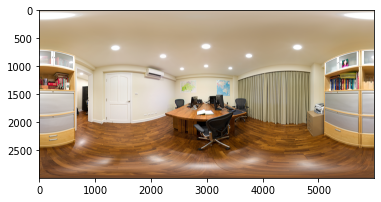

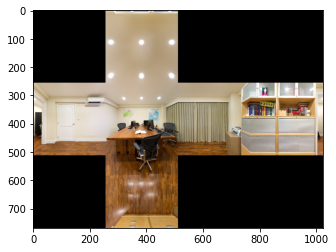

In [22]:
def e2c(e_img, face_w, mode, cube_format):
    '''
    e_img:  ndarray in shape of [H, W, *]
    face_w: int, the length of each face of the cubemap
    '''
    assert len(e_img.shape) == 3
    h, w = e_img.shape[:2]
    if mode == 'bilinear':
        order = 1
    elif mode == 'nearest':
        order = 0
    else:
        raise NotImplementedError('unknown mode')

    xyz = xyzcube(face_w)
    # print(xyz)
    uv = xyz2uv(xyz)
    # print(uv)
    # print(h,w)
    coor_xy = uv2coor(uv, h, w)
    # print(coor_xy)
    cubemap = np.stack([
        sample_equirec(e_img[..., i], coor_xy, order=order)
        for i in range(e_img.shape[2])
    ], axis=-1)
    # print(cubemap)
    # return cubemap
    if cube_format == 'horizon':
        pass
    elif cube_format == 'list':
        cubemap = cube_h2list(cubemap)
    elif cube_format == 'dict':
        cubemap = cube_h2dict(cubemap)
    elif cube_format == 'dice':
        cubemap = cube_h2dice(cubemap)
    else:
        raise NotImplementedError()

    return cubemap
image_url="drive/My Drive/Design_Credit/Data_Set/Stimuli/P27_6000x3000.jpg"
image=PIL.Image.open(image_url)
image=np.asarray(image)
plt.imshow(image)
plt.show()
img=e2c(image,256,'bilinear','dice')
plt.imshow(img)
plt.show()


In [23]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

## **Scilency Conversion Methods**


*   GBVS



In [24]:
def solve(mat, tolerance):
    w,h = mat.shape
    diff = 1
    v = np.divide(np.ones((w, 1), dtype=np.float32), w)
    oldv = v
    oldoldv = v

    while diff > tolerance :
        oldv = v
        oldoldv = oldv
        v = np.dot(mat,v)
        diff = np.linalg.norm(oldv - v, ord=2)
        s = sum(v)
        if s>=0 and s< np.inf:
            continue
        else:
            v = oldoldv
            break

    v = np.divide(v, sum(v))

    return v

In [25]:
def loadGraphDistanceMatrixFor28x32():
    f = scipy.io.loadmat("drive/My Drive/Design_Credit/Additional Files/28__32__m__2.mat")
    distanceMat = np.array(f['grframe'])[0][0][0]
    lx = np.array(f['grframe'])[0][0][1]
    dim = np.array(f['grframe'])[0][0][2]
    return [distanceMat, lx, dim]

In [26]:
def calculate(map, sigma):
    [distanceMat, _, _] = loadGraphDistanceMatrixFor28x32()
    denom = 2 * pow(sigma, 2)
    expr = -np.divide(distanceMat, denom)
    Fab = np.exp(expr)

    map_linear = np.ravel(map, order='F')  # column major

    state_transition_matrix = Fab * np.abs(
        (np.zeros((distanceMat.shape[0], distanceMat.shape[1])) + map_linear).T - map_linear).T

    norm_STM = sklearn.preprocessing.normalize(state_transition_matrix, axis=0, norm='l1')

    eVec = solve(norm_STM, 0.0001)
    processed_reshaped = np.reshape(eVec, map.shape, order='F')

    return processed_reshaped

In [27]:
def normalize(map, sigma):
    [distanceMat, _, _] = loadGraphDistanceMatrixFor28x32()
    denom = 2 * pow(sigma, 2)
    expr = -np.divide(distanceMat, denom)
    Fab = np.exp(expr)

    map_linear = np.ravel(map, order='F')
    state_transition_matrix = (Fab.T * np.abs(map_linear)).T

    norm_STM = sklearn.preprocessing.normalize(state_transition_matrix, axis=0, norm='l1')

    eVec = solve(norm_STM, 0.0001)
    processed_reshaped = np.reshape(eVec, map.shape, order='F')

    return processed_reshaped

In [28]:
def compute(r, g, b, L):
    min_rg = np.minimum(r, g)
    b_min_rg = np.abs(np.subtract(b, min_rg))
    CBY = np.divide(b_min_rg, L, out=np.zeros_like(L), where=L != 0)

    r_g = np.abs(np.subtract(r,g))
    CRG = np.divide(r_g, L, out=np.zeros_like(L), where=L != 0)

    featMaps = {}
    featMaps['CBY'] = CBY
    featMaps['CRG'] = CRG
    featMaps['L'] = L
    return featMaps

In [29]:
def getGaborKernel(gaborparams, angle, phase):
    gp = gaborparams
    major_sd = gp['stddev']
    minor_sd = major_sd * gp['elongation']
    max_sd = max(major_sd, minor_sd)

    sz = gp['filterSize']
    if sz == -1:
        sz = math.ceil(max_sd * math.sqrt(10))
    else:
        sz = math.floor(sz / 2)

    psi = np.pi / 180 * phase
    rtDeg = np.pi / 180 * angle

    omega = 2 * np.pi / gp['filterPeriod']
    co = math.cos(rtDeg)
    si = -math.sin(rtDeg)
    major_sigq = 2 * pow(major_sd, 2)
    minor_sigq = 2 * pow(minor_sd, 2)

    vec = range(-int(sz), int(sz) + 1)
    vlen = len(vec)
    vco = [i * co for i in vec]
    vsi = [i * si for i in vec]

    # major = np.matlib.repmat(np.asarray(vco).transpose(), 1, vlen) + np.matlib.repmat(vsi, vlen, 1)
    a = np.tile(np.asarray(vco).transpose(), (vlen, 1)).transpose()
    b = np.matlib.repmat(vsi, vlen, 1)
    major = a + b
    major2 = np.power(major, 2)

    # minor = np.matlib.repmat(np.asarray(vsi).transpose(), 1, vlen) - np.matlib.repmat(vco, vlen, 1)
    a = np.tile(np.asarray(vsi).transpose(), (vlen, 1)).transpose()
    b = np.matlib.repmat(vco, vlen, 1)
    minor = a + b
    minor2 = np.power(minor, 2)

    a = np.cos(omega * major + psi)
    b = np.exp(-major2 / major_sigq - minor2 / minor_sigq)
    # result = np.cos(omega * major + psi) * exp(-major2/major_sigq - minor2/minor_sigq)
    result = np.multiply(a, b)

    filter1 = np.subtract(result, np.mean(result.reshape(-1)))
    filter1 = np.divide(filter1, np.sqrt(np.sum(np.power(filter1.reshape(-1), 2))))
    return filter1

In [30]:
def getGaborKernels(gaborparams, thetas):
    gaborKernels = {}
    for th in thetas:
        gaborKernels[th] = {}
        gaborKernels[th]['0'] = getGaborKernel(gaborparams, th, 0)
        gaborKernels[th]['90'] = getGaborKernel(gaborparams, th, 90)

    return gaborKernels

In [31]:
def orientcompute(L, gaborparams, thetas):
    # L = Intensity Map
    # L = np.maximum(np.maximum(r, g), b)

    kernels = getGaborKernels(gaborparams, thetas)
    featMaps = []
    for th in thetas:
        kernel_0  = kernels[th]['0']
        kernel_90 = kernels[th]['90']
        o1 = cv2.filter2D(L, -1, kernel_0, borderType=cv2.BORDER_REPLICATE)
        o2 = cv2.filter2D(L, -1, kernel_90, borderType=cv2.BORDER_REPLICATE)
        o = np.add(abs(o1), abs(o2))
        featMaps.append(o)

    return featMaps

In [32]:
def calculateFeatureMaps(r, g, b, L, params):
    colorMaps = compute(r, g, b, L)
    orientationMaps = orientcompute(L, params['gaborparams'], params['thetas'])
    allFeatureMaps = {
        0: colorMaps['CBY'],
        1: colorMaps['CRG'],
        2: colorMaps['L'],
        3: orientationMaps
    }
    return allFeatureMaps

In [33]:
def getPyramids(image, max_level):
    imagePyr = [cv2.pyrDown(image)]
    for i in range(1, max_level):
        # imagePyr.append(cv2.resize(p, (32, 28), interpolation=cv2.INTER_CUBIC))
        imagePyr.append(cv2.pyrDown(imagePyr[i-1]))
    return imagePyr[1:]

In [34]:
def run(image, params):
    b = image[:,:,0]
    g = image[:,:,1]
    r = image[:,:,2]
    L = np.maximum(np.maximum(r, g), b)

    b_pyr = getPyramids(b, params['max_level'])
    g_pyr = getPyramids(g, params['max_level'])
    r_pyr = getPyramids(r, params['max_level'])
    L_pyr = getPyramids(L, params['max_level'])

    featMaps = {
        0: [],
        1: [],
        2: [],
        3: []
    }

    for i in range(0, len(b_pyr)):
        p_r = r_pyr[i]
        p_g = g_pyr[i]
        p_b = b_pyr[i]
        p_L = L_pyr[i]

        maps = calculateFeatureMaps(p_r, p_g, p_b, p_L, params)

        for i in range(0,3):
            resized_m = cv2.resize(maps[i], (32, 28), interpolation=cv2.INTER_CUBIC)
            featMaps[i].append(resized_m)

        for m in maps[3]:
            resized_m = cv2.resize(m, (32, 28), interpolation=cv2.INTER_CUBIC)
            featMaps[3].append(resized_m)
        # featMaps[0].append(maps[0])
        # featMaps[1].append(maps[1])
        # featMaps[2].append(maps[2])

    activationMaps = []
    activation_sigma = params['sigma_frac_act']*np.mean([32, 28]) # the shape of map

    for i in range(0,4):
        for map in featMaps[i]:
            activationMaps.append(calculate(map, activation_sigma))

    normalisedActivationMaps = []
    normalisation_sigma = params['sigma_frac_norm']*np.mean([32, 28])

    for map in activationMaps:
        normalisedActivationMaps.append(normalize(map, normalisation_sigma))

    mastermap = normalisedActivationMaps[0]
    for i in range(1, len(normalisedActivationMaps)):
        mastermap = np.add(normalisedActivationMaps[i], mastermap)


    # post process

    gray = cv2.normalize(mastermap, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    # blurred = cv2.GaussianBlur(gray,(4,4), 4)
    # gray2 = cv2.normalize(blurred, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    mastermap_res = cv2.resize(gray, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_CUBIC)

    return mastermap_res

In [35]:
def setupParams():
    gaborparams = {
        'stddev': 2,
        'elongation': 2,
        'filterSize': -1,
        'filterPeriod': np.pi
    }

    params = {
        'gaborparams': gaborparams,
        'sigma_frac_act': 0.15,
        'sigma_frac_norm': 0.06,
        'max_level': 4,
        'thetas': [0, 45, 90, 135]
    }

    return params

In [36]:
def compute_saliency(input_image):
    if type(input_image) is str:
        input_image = cv2.imread(input_image)

    params = setupParams()
    return run(image=input_image / 255.0, params=params) * 255.0

## **Distortion analysis Measures**


1.   AUC_Borji
2.   NSS
3.   CC
4.   SIM
5.   KLD


## **Binary Salmap and convertion (RGB to Binary and vice versa)**

# **Working on Single Image**

### **importing**

In [37]:
image_url="drive/My Drive/Design_Credit/Data_Set/Stimuli/P27_6000x3000.jpg"
sailmap_url ="drive/My Drive/Design_Credit/Data_Set/SalMaps/Hsalmap_27.png"
bin_sailMap_url="drive/My Drive/Design_Credit/Data_Set/SalMaps/Hsalmap_27_2048x1024_32b.bin"

In [38]:
width=4000
height=2000
dtype=32

In [39]:
image=PIL.Image.open(image_url)
image=np.asarray(image)
salMap=PIL.Image.open(sailmap_url)
salMap=np.asarray(salMap)
with open(bin_sailMap_url, 'rb') as f:
  Map=np.fromfile(f, count=2048*1024, dtype=np.float32)
  Map=Map.reshape([1024,2048])

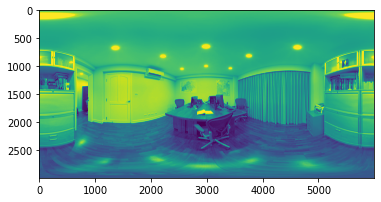

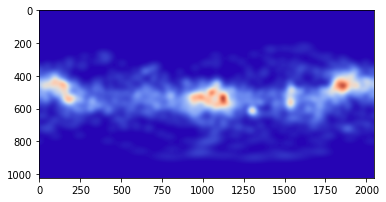

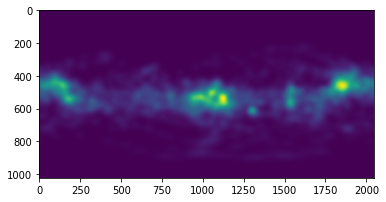

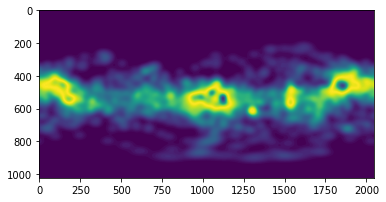

In [40]:
plt.imshow(rgb2gray(image))
plt.show()
plt.imshow(salMap)
plt.show()
plt.imshow(Map)
plt.show()
plt.imshow(rgb2gray(salMap))

In [41]:
np.shape(rgb2gray(image))

(3000, 6000)

### **interpretation**

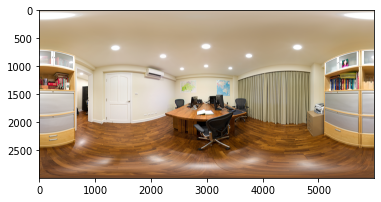

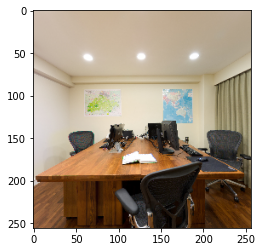

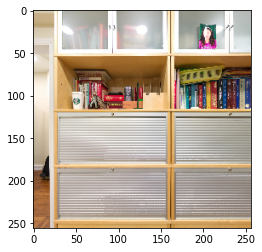

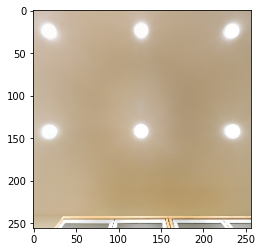

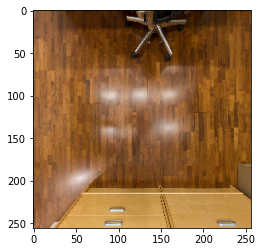

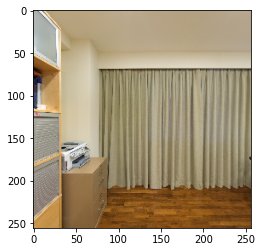

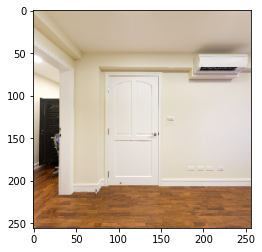

In [42]:
plt.imshow(image)
plt.show()
i_cmpdict={}
for i in e2c(image,256,'bilinear','dict').keys():
  i_cmpdict[i]=e2c(image,256,'bilinear','dict')[i]

i_front, i_back, i_top, i_down, i_right, i_left = i_cmpdict['F'], i_cmpdict['B'], i_cmpdict['U'], i_cmpdict['D'], i_cmpdict['R'], i_cmpdict['L']

s_cmpdict={}
for i in e2c(salMap,256,'bilinear','dict').keys():
  s_cmpdict[i]=e2c(salMap,256,'bilinear','dict')[i]

s_front, s_back, s_top, s_down, s_right, s_left = s_cmpdict['F'], s_cmpdict['B'], s_cmpdict['U'], s_cmpdict['D'], s_cmpdict['R'], s_cmpdict['L']
plt.imshow(i_front)
plt.show()
plt.imshow(i_back)
plt.show()
plt.imshow(i_top)
plt.show()
plt.imshow(i_down)
plt.show()
plt.imshow(i_right)
plt.show()
plt.imshow(i_left)
plt.show()

<PIL.Image.Image image mode=RGB size=1024x768 at 0x7F1B6CC32850>


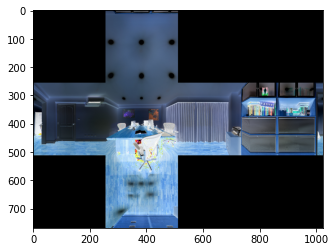

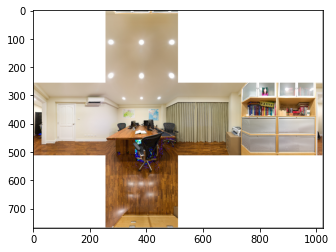

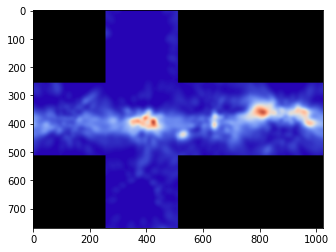

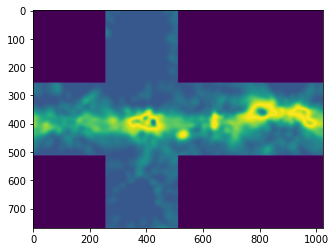

In [43]:
temp=tensor_to_image(np.asarray(e2c(image,256,'bilinear','dice')))
print(temp)
plt.imshow(temp)
plt.show()

var=tensor_to_image(np.asarray(e2c(image,256,'bilinear','dice')))
for i in range(0, var.size[0]-1):
  for j in range(0, var.size[1]-1):
    pixelColorVals = var.getpixel((i,j));
    redPixel    = 255 - pixelColorVals[0]; # Negate red pixel
    greenPixel  = 255 - pixelColorVals[1]; # Negate green pixel
    bluePixel   = 255 - pixelColorVals[2]; # Negate blue pixel
    var.putpixel((i,j),(redPixel, greenPixel, bluePixel));
plt.imshow(var)
plt.show()


plt.imshow(e2c(salMap,256,'bilinear','dice'))
plt.show()
plt.imshow(rgb2gray(e2c(salMap,256,'bilinear','dice')))
plt.show()

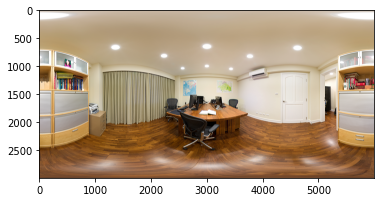

In [44]:
image_flip=PIL.Image.fromarray(np.fliplr(image))
plt.imshow(image_flip)
plt.show()

### **silency conversion**

(768, 1024)


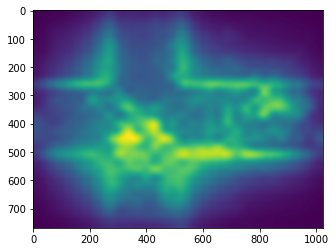

In [45]:
p=compute_saliency(np.asarray(e2c(image,256,'bilinear','dice')))
print(np.shape(p))
plt.imshow(p)
plt.show()

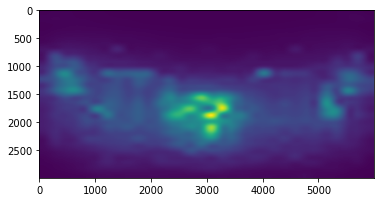

In [46]:
q=compute_saliency(np.fliplr(image))
plt.imshow(q)
plt.show()

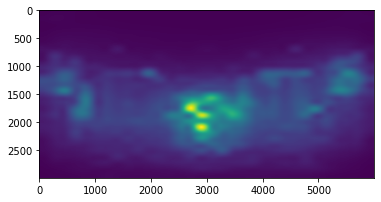

In [47]:
r=compute_saliency(image)
plt.imshow(r)
plt.show()

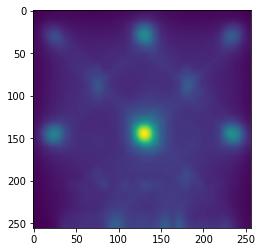

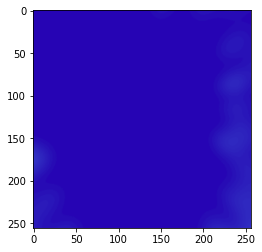

In [48]:
s=compute_saliency(i_top)
plt.imshow(s)
plt.show()
plt.imshow(s_top)
plt.show()

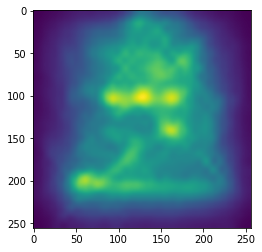

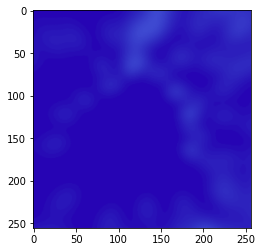

In [49]:
t=compute_saliency(i_down)
plt.imshow(t)
plt.show()
plt.imshow(s_down)

### **recombining**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


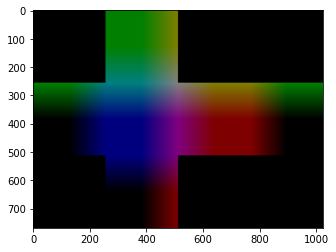

In [50]:
def xyzcube_grey(face_w):
    '''
    Return the xyz cordinates of the unit cube in [F R B L U D] format.
    '''
    out = np.zeros((face_w, face_w * 6,3), np.float32)
    # plt.imshow(out)
    # plt.show()
    rng = np.linspace(-0.5, 0.5, num=face_w, dtype=np.float32)
    grid = np.stack(np.meshgrid(rng, -rng), -1)
    # print(grid)
    # grid=grid.mean(axis=-1)
    # plt.imshow(grid)
    # plt.show()
   
    # Front face (z = 0.5)
    out[:, 0*face_w:1*face_w, [0, 1]] = grid
    out[:, 0*face_w:1*face_w,2] = 0.5

    # Right face (x = 0.5)
    out[:, 1*face_w:2*face_w, [2, 1]] = grid
    out[:, 1*face_w:2*face_w,0] = 0.5

    # Back face (z = -0.5)
    out[:, 2*face_w:3*face_w, [0, 1]] = grid
    out[:, 2*face_w:3*face_w,2] = -0.5

    # Left face (x = -0.5)
    out[:, 3*face_w:4*face_w, [2, 1]] = grid
    out[:, 3*face_w:4*face_w,0] =-0.5

    # Up face (y = 0.5)
    out[:, 4*face_w:5*face_w, [0, 2]] = grid
    out[:, 4*face_w:5*face_w,1] = 0.5

    # Down face (y = -0.5)
    out[:, 5*face_w:6*face_w, [0, 2]] = grid
    out[:, 5*face_w:6*face_w,1] = -0.5
    
    return out
def xyzcubetmp(face_w):
    '''
    Return the xyz cordinates of the unit cube in [F R B L U D] format.
    '''
    out = np.zeros((face_w, face_w * 6, 3), np.float32)
    rng = np.linspace(-0.5, 0.5, num=face_w, dtype=np.float32)
    grid = np.stack(np.meshgrid(rng, -rng), -1)

    # Front face (z = 0.5)
    out[:, 0*face_w:1*face_w, [0, 1]] = grid
    out[:, 0*face_w:1*face_w, 2] = 0

    # Right face (x = 0.5)
    out[:, 1*face_w:2*face_w, [2, 1]] = grid
    out[:, 1*face_w:2*face_w, 0] = 0

    # Back face (z = -0.5)
    out[:, 2*face_w:3*face_w, [0, 1]] = grid
    out[:, 2*face_w:3*face_w, 2] = 0

    # Left face (x = -0.5)
    out[:, 3*face_w:4*face_w, [2, 1]] = grid
    out[:, 3*face_w:4*face_w, 0] = 0

    # Up face (y = 0.5)
    out[:, 4*face_w:5*face_w, [0, 2]] = grid
    out[:, 4*face_w:5*face_w, 1] = 0

    # Down face (y = -0.5)
    out[:, 5*face_w:6*face_w, [0, 2]] = grid
    out[:, 5*face_w:6*face_w, 1] = 0

    return out

grayoup=xyzcube_grey(256)
grayoupdice=cube_h2dice(grayoup)
plt.imshow(grayoupdice)
plt.show()
# oup=xyzcube(256)
# oupdice=cube_h2dice(oup)
# plt.imshow(rgb2gray(oupdice))
# plt.show()
# tmpoup=xyzcubetmp(256)
# tmpoupdice=cube_h2dice(tmpoup)
# plt.imshow(rgb2gray(tmpoupdice))
# print(oup)
# oup=(xyzcube(256))
# oup=cube_h2dice(oup)
# grayoup=oup.mean(axis=-1)
# plt.imshow(grayoup)
# plt.show()

In [51]:
def c2e(cubemap, h, w, mode='bilinear', cube_format='dice'):
    if mode == 'bilinear':
        order = 1
    elif mode == 'nearest':
        order = 0
    else:
        raise NotImplementedError('unknown mode')

    if cube_format == 'horizon':
        pass
    elif cube_format == 'list':
        cubemap = cube_list2h(cubemap)
    elif cube_format == 'dict':
        cubemap = cube_dict2h(cubemap)
    elif cube_format == 'dice':
        cubemap = cube_dice2h(cubemap)
    else:
        raise NotImplementedError('unknown cube_format')
    assert len(cubemap.shape) == 3
    assert cubemap.shape[0] * 6 == cubemap.shape[1]
    assert w % 8 == 0
    face_w = cubemap.shape[0]

    uv = equirect_uvgrid(h, w)
    u, v = np.split(uv, 2, axis=-1)
    u = u[..., 0]
    v = v[..., 0]
    cube_faces = np.stack(np.split(cubemap, 6, 1), 0)

    # Get face id to each pixel: 0F 1R 2B 3L 4U 5D
    tp = equirect_facetype(h, w)
    coor_x = np.zeros((h, w))
    coor_y = np.zeros((h, w))

    for i in range(4):
        mask = (tp == i)
        coor_x[mask] = 0.5 * np.tan(u[mask] - np.pi * i / 2)
        coor_y[mask] = -0.5 * np.tan(v[mask]) / np.cos(u[mask] - np.pi * i / 2)

    mask = (tp == 4)
    c = 0.5 * np.tan(np.pi / 2 - v[mask])
    coor_x[mask] = c * np.sin(u[mask])
    coor_y[mask] = c * np.cos(u[mask])

    mask = (tp == 5)
    c = 0.5 * np.tan(np.pi / 2 - np.abs(v[mask]))
    coor_x[mask] = c * np.sin(u[mask])
    coor_y[mask] = -c * np.cos(u[mask])

    # Final renormalize
    coor_x = (np.clip(coor_x, -0.5, 0.5) + 0.5) * face_w
    coor_y = (np.clip(coor_y, -0.5, 0.5) + 0.5) * face_w

    equirec = np.stack([
        sample_cubefaces(cube_faces[..., i], tp, coor_y, coor_x, order=order)
        for i in range(cube_faces.shape[3])
    ], axis=-1)

    return equirec

(768, 1024, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


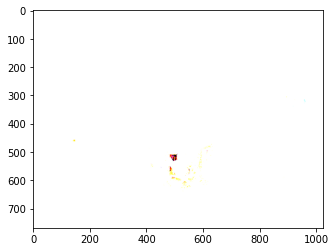

In [52]:
#c2e(p, 3000,6000)
print(np.shape(e2c(image,256,'bilinear','dice')))
plt.imshow(c2e(e2c(image,256,'bilinear','dice'),768,1024))
plt.show()


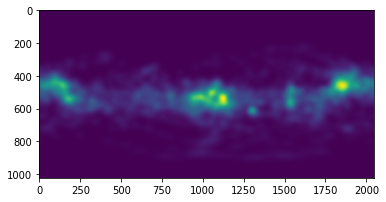

In [53]:
plt.imshow(Map)
plt.show()

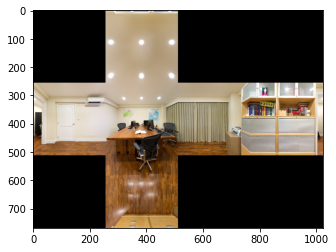

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


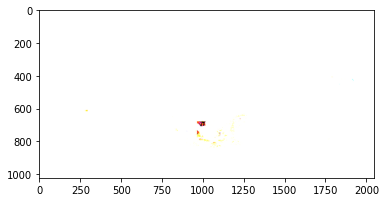

In [54]:
q=e2c(image, 256, 'bilinear', 'dice')
plt.imshow(q)
plt.show()
w=c2e(q, 1024,2048,'bilinear','dice')
plt.imshow(w)
plt.show()

In [55]:
print(np.shape(var))
a=c2e(var,1024,2048,'bilinear','dice')
#equisal=np.squeeze(a,axis=(2,))
print(a.shape)
# rgbequisal=cv2.merge([equisal,equisal,equisal])
# rgbequisal=cv2.cvtColor(equisal,cv2.COLOR_GRAY2RGB)
plt.imshow(a)
plt.show()

(768, 1024, 3)


AttributeError: ignored

# **Modelling on Entire Data**